# Five-Year Snow Cover Analysis (Year-Round)
## Scottish Highlands: Ben Nevis & Ben Macdui

This notebook downloads and analyzes snow cover data year-round from 2021-2025 for two mountain regions in the Scottish Highlands.

**Workflow:**
1. Setup database and define Areas of Interest (AOIs)
2. Download Sentinel-2 imagery for all seasons (2021-2025)
3. Process snow masks using NDSI threshold
4. Visualize B03 band data with geographic coordinates
5. Analyze and plot continuous snow coverage trends throughout the year

## Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
from datetime import datetime

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Imports
from data_handler.aoi import get_aois
from data_handler.discovery import create_sh_config, find_sentinel_products
from data_handler.download import download_product
from data_handler.notebook_utils import create_aoi_map
from data_handler.demo_utils import (
    setup_database_and_aois,
    load_b03_images_from_db,
    plot_b03_with_coordinates,
    compute_snow_masks_for_aoi,
    analyze_snow_trends,
    plot_snow_trends
)
from data_handler.repositories import AOIRepository, SentinelProductRepository, DownloadStatusRepository
from data_handler.models import SentinelProduct, DownloadStatus
from shapely.geometry import box

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Imports successful")

✓ Imports successful


## 1. Define Areas of Interest (AOIs)

We monitor two mountain regions in the Scottish Highlands:
- **Ben Nevis** (56.7969°N, 5.0036°W) - Highest peak in the British Isles
- **Ben Macdui** (57.0704°N, 3.6691°W) - Second highest peak

Each AOI is a 10km × 10km bounding box centered on the mountain peak.

In [2]:
# Load AOI definitions
aois_gdf = get_aois()
print(f"Loaded {len(aois_gdf)} Areas of Interest:")
print()
for idx, row in aois_gdf.iterrows():
    print(f"  {row['name']}:")
    print(f"    Center: {row['center_lat']:.4f}°N, {row['center_lon']:.4f}°E")
    print(f"    Size: {row['size_km']} km × {row['size_km']} km")
    bounds = row['geometry'].bounds
    print(f"    Bounding box: ({bounds[0]:.4f}, {bounds[1]:.4f}) to ({bounds[2]:.4f}, {bounds[3]:.4f})")
    print()

Loaded 2 Areas of Interest:

  Ben Nevis:
    Center: 56.7969°N, -5.0036°E
    Size: 10.0 km × 10.0 km
    Bounding box: (-5.0856, 56.7520) to (-4.9216, 56.8418)

  Ben Macdui:
    Center: 57.0704°N, -3.6691°E
    Size: 10.0 km × 10.0 km
    Bounding box: (-3.7517, 57.0255) to (-3.5865, 57.1153)



In [3]:
# Display AOIs on interactive map
aoi_map = create_aoi_map(aois_gdf)
aoi_map

## 2. Initialize Database and Configuration

Create database schema and insert AOI definitions.

In [4]:
# Setup database
db_path = "../data/five_year_analysis.db"
session, aoi_records = setup_database_and_aois(db_path=db_path)

print(f"✓ Database initialized: {db_path}")
print(f"✓ Loaded {len(aoi_records)} AOIs into database")

✓ Database initialized: ../data/five_year_analysis.db
✓ Loaded 2 AOIs into database


In [5]:
# Create SentinelHub configuration
# Requires environment variables: SH_CLIENT_ID, SH_CLIENT_SECRET
try:
    config = create_sh_config()
    print("✓ SentinelHub configuration created")
except ValueError as e:
    print(f"⚠ Warning: {e}")
    print("Set credentials with: export SH_CLIENT_ID='...' and export SH_CLIENT_SECRET='...'")
    config = None

✓ SentinelHub configuration created


## 3. Download Year-Round Data for Five Years

We'll download Sentinel-2 imagery for the complete years:
- 2021 (Jan 1 - Dec 31, 2021)
- 2022 (Jan 1 - Dec 31, 2022)
- 2023 (Jan 1 - Dec 31, 2023)
- 2024 (Jan 1 - Dec 31, 2024)
- 2025 (Jan 1 - Dec 31, 2025)

**Cloud cover threshold:** 50%  
**Note:** This will download a large amount of data and take significant time.

In [6]:
# Skip download if config is not available
if config is None:
    print("⚠ Skipping download - no SentinelHub configuration available")
    print("Using existing data in database if available")
else:
    # Download data for each full year
    years = [2021, 2022, 2023, 2024, 2025]
    max_cloud_cover = 50.0
    
    all_stats = {}
    
    # Get AOI repository
    aoi_repo = AOIRepository(session)
    product_repo = SentinelProductRepository(session)
    status_repo = DownloadStatusRepository(session)
    
    for year in years:
        print(f"\n{'='*80}")
        print(f"YEAR {year}")
        print(f"{'='*80}")
        
        # Define date range for full year
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31, 23, 59, 59)
        
        year_stats = {
            'products_discovered': 0,
            'products_inserted': 0,
            'products_downloaded': 0,
            'products_failed': 0
        }
        
        # Process each AOI
        for aoi in aoi_records:
            print(f"\n  Processing AOI: {aoi.name}")
            print(f"    Center: ({aoi.center_lat:.4f}°N, {aoi.center_lon:.4f}°E)")
            print(f"    Date range: {start_date.date()} to {end_date.date()}")
            print(f"    Cloud threshold: {max_cloud_cover}%")
            
            # Create search polygon
            search_polygon = box(
                aoi.center_lon - 0.05,
                aoi.center_lat - 0.05,
                aoi.center_lon + 0.05,
                aoi.center_lat + 0.05
            )
            
            # Discover products
            print(f"    Discovering products...")
            try:
                products_df = find_sentinel_products(
                    config=config,
                    bbox=search_polygon,
                    start_date=start_date,
                    end_date=end_date,
                    max_cloud_cover=max_cloud_cover
                )
                year_stats['products_discovered'] += len(products_df)
                print(f"    ✓ Found {len(products_df)} products")
            except Exception as e:
                print(f"    ✗ Discovery failed: {str(e)[:100]}")
                continue
            
            if len(products_df) == 0:
                print(f"    No products found")
                continue
            
            # Insert products into database
            print(f"    Inserting products into database...")
            for _, row in products_df.iterrows():
                # Check if product already exists
                existing = product_repo.get_by_product_id(row['product_id'])
                if existing:
                    continue
                
                # Create product record
                product = product_repo.create(
                    product_id=row['product_id'],
                    aoi_id=aoi.id,
                    acquisition_dt=row['date'],
                    cloud_cover=row['cloud_cover'],
                    geometry=str(row.get('geometry', '{}'))
                )
                
                # Create download status
                status_repo.create(product_id=product.id, status='pending')
                year_stats['products_inserted'] += 1
            
            print(f"    ✓ Inserted {year_stats['products_inserted']} new products")
            
            # Download products
            if year_stats['products_inserted'] > 0:
                print(f"    Downloading products...")
                
                # Get pending downloads for this AOI
                pending = session.query(DownloadStatus).join(SentinelProduct).filter(
                    SentinelProduct.aoi_id == aoi.id,
                    DownloadStatus.status == 'pending'
                ).all()
                
                for idx, status in enumerate(pending, 1):
                    product = status.product
                    print(f"      [{idx}/{len(pending)}] {product.acquisition_dt.date()}...", end=" ")
                    
                    success, error, file_path = download_product(
                        session,
                        product.id,
                        config=config
                    )
                    
                    if success:
                        print(f"✓")
                        year_stats['products_downloaded'] += 1
                    else:
                        print(f"✗ {error[:40] if error else 'Error'}")
                        year_stats['products_failed'] += 1
        
        all_stats[year] = year_stats
        print(f"\n  Year {year} Summary:")
        print(f"    Discovered: {year_stats['products_discovered']} products")
        print(f"    Inserted: {year_stats['products_inserted']} products")
        print(f"    Downloaded: {year_stats['products_downloaded']} products")
        print(f"    Failed: {year_stats['products_failed']} products")
    
    # Overall summary
    print(f"\n{'='*80}")
    print("OVERALL SUMMARY (ALL YEARS)")
    print(f"{'='*80}")
    total_discovered = sum(s['products_discovered'] for s in all_stats.values())
    total_inserted = sum(s['products_inserted'] for s in all_stats.values())
    total_downloaded = sum(s['products_downloaded'] for s in all_stats.values())
    total_failed = sum(s['products_failed'] for s in all_stats.values())
    print(f"  Total discovered: {total_discovered} products")
    print(f"  Total inserted: {total_inserted} products")
    print(f"  Total downloaded: {total_downloaded} products")
    print(f"  Total failed: {total_failed} products")


YEAR 2021

  Processing AOI: Ben Nevis
    Center: (56.7969°N, -5.0036°E)
    Date range: 2021-01-01 to 2021-12-31
    Cloud threshold: 50.0%
    Discovering products...
    ✓ Found 59 products
    Inserting products into database...
    ✓ Inserted 43 new products
      [1/48] 2021-01-02... ✓
      [2/48] 2021-01-02... ✓
      [3/48] 2020-12-23... ✓
      [4/48] 2020-12-06... ✓
      [5/48] 2020-12-06... ✓
      [6/48] 2021-12-18... ✓
      [7/48] 2021-12-18... ✓
      [8/48] 2021-12-01... ✓
      [9/48] 2021-11-28... ✓
      [10/48] 2021-11-28... ✓
      [11/48] 2021-11-26... ✓
      [12/48] 2021-11-21... ✓
      [13/48] 2021-11-21... ✓
      [14/48] 2021-11-03... ✓
      [15/48] 2021-10-24... ✓
      [16/48] 2021-10-22... ✓
      [17/48] 2021-09-29... ✓
      [18/48] 2021-09-02... ✓
      [19/48] 2021-08-25... ✓
      [20/48] 2021-08-25... ✓
      [21/48] 2021-07-21... ✓
      [22/48] 2021-07-21... ✓
      [23/48] 2021-07-19... ✓
      [24/48] 2021-07-01... ✓
      [25/48] 2021-07-0

## 4. Visualize B03 Band Data (Green Band)

Display example B03 (green) band images with geographic coordinates (latitude/longitude).

The B03 band is useful for visualizing surface features and is one of the components used in the NDSI calculation.

Loaded 6 B03 images for Ben Nevis


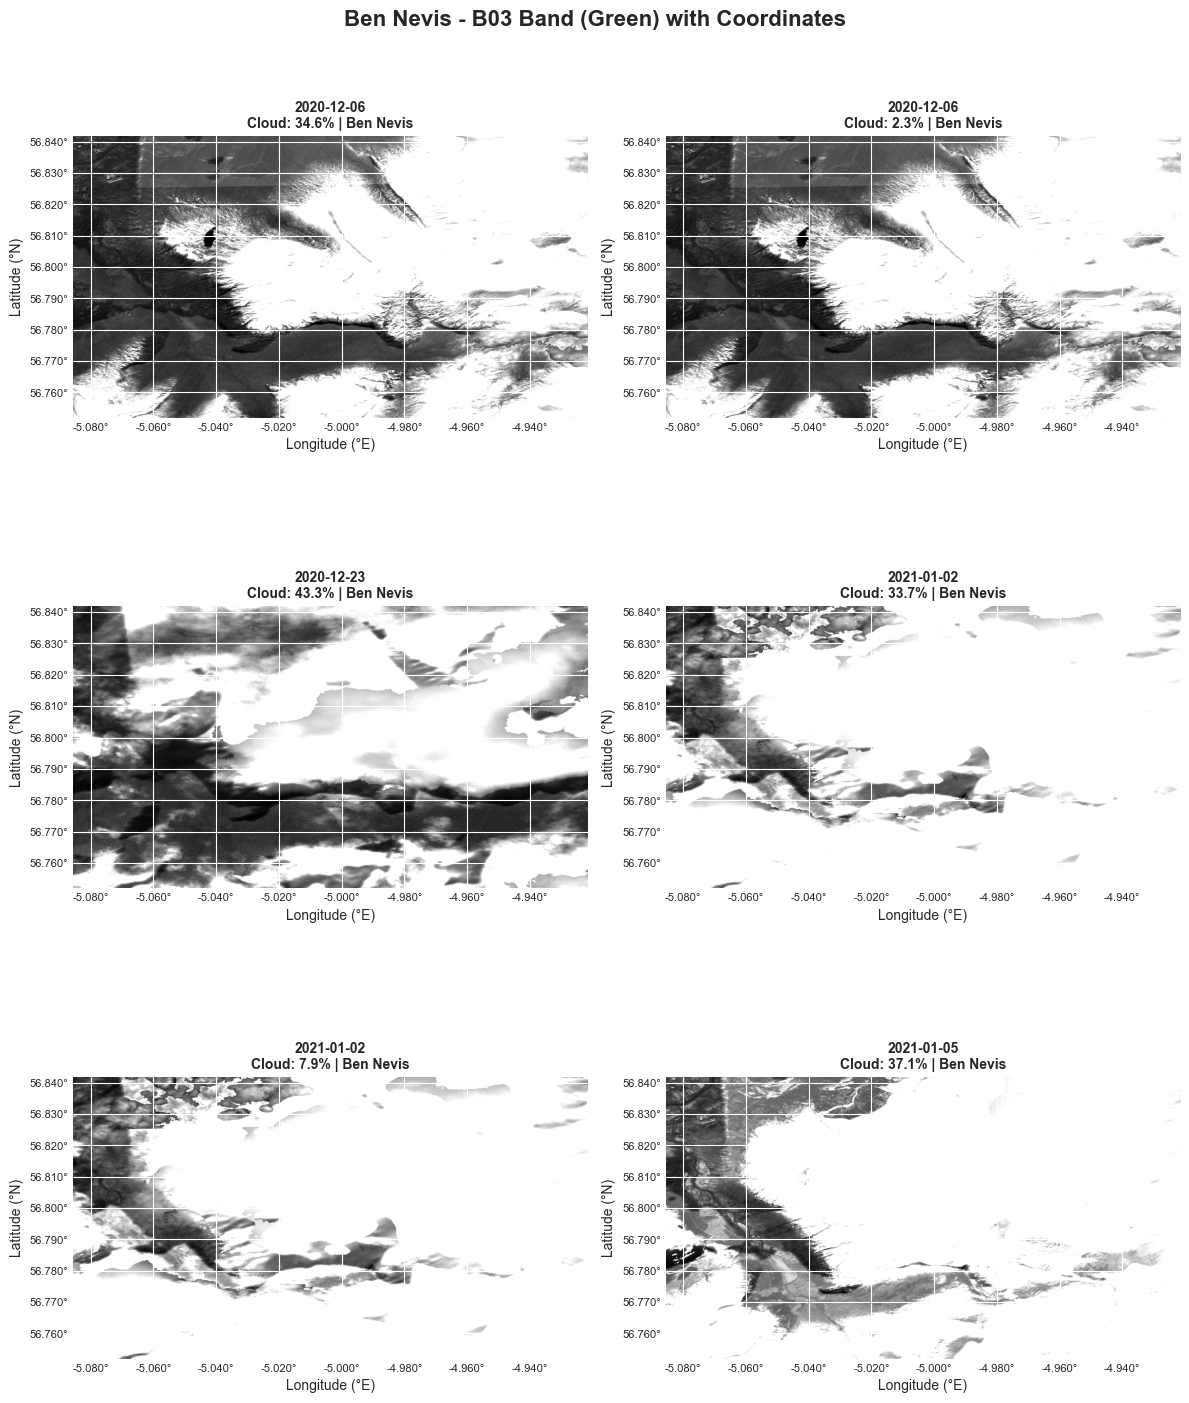

In [7]:
# Load B03 images for Ben Nevis
ben_nevis_images = load_b03_images_from_db(session, aoi_name='Ben Nevis', limit=6)
print(f"Loaded {len(ben_nevis_images)} B03 images for Ben Nevis")

if len(ben_nevis_images) > 0:
    fig = plot_b03_with_coordinates(
        ben_nevis_images,
        title="Ben Nevis - B03 Band (Green) with Coordinates",
        ncols=2,
        brightness_factor=3.0
    )
    plt.show()
else:
    print("No images available for Ben Nevis")

Loaded 6 B03 images for Ben Macdui


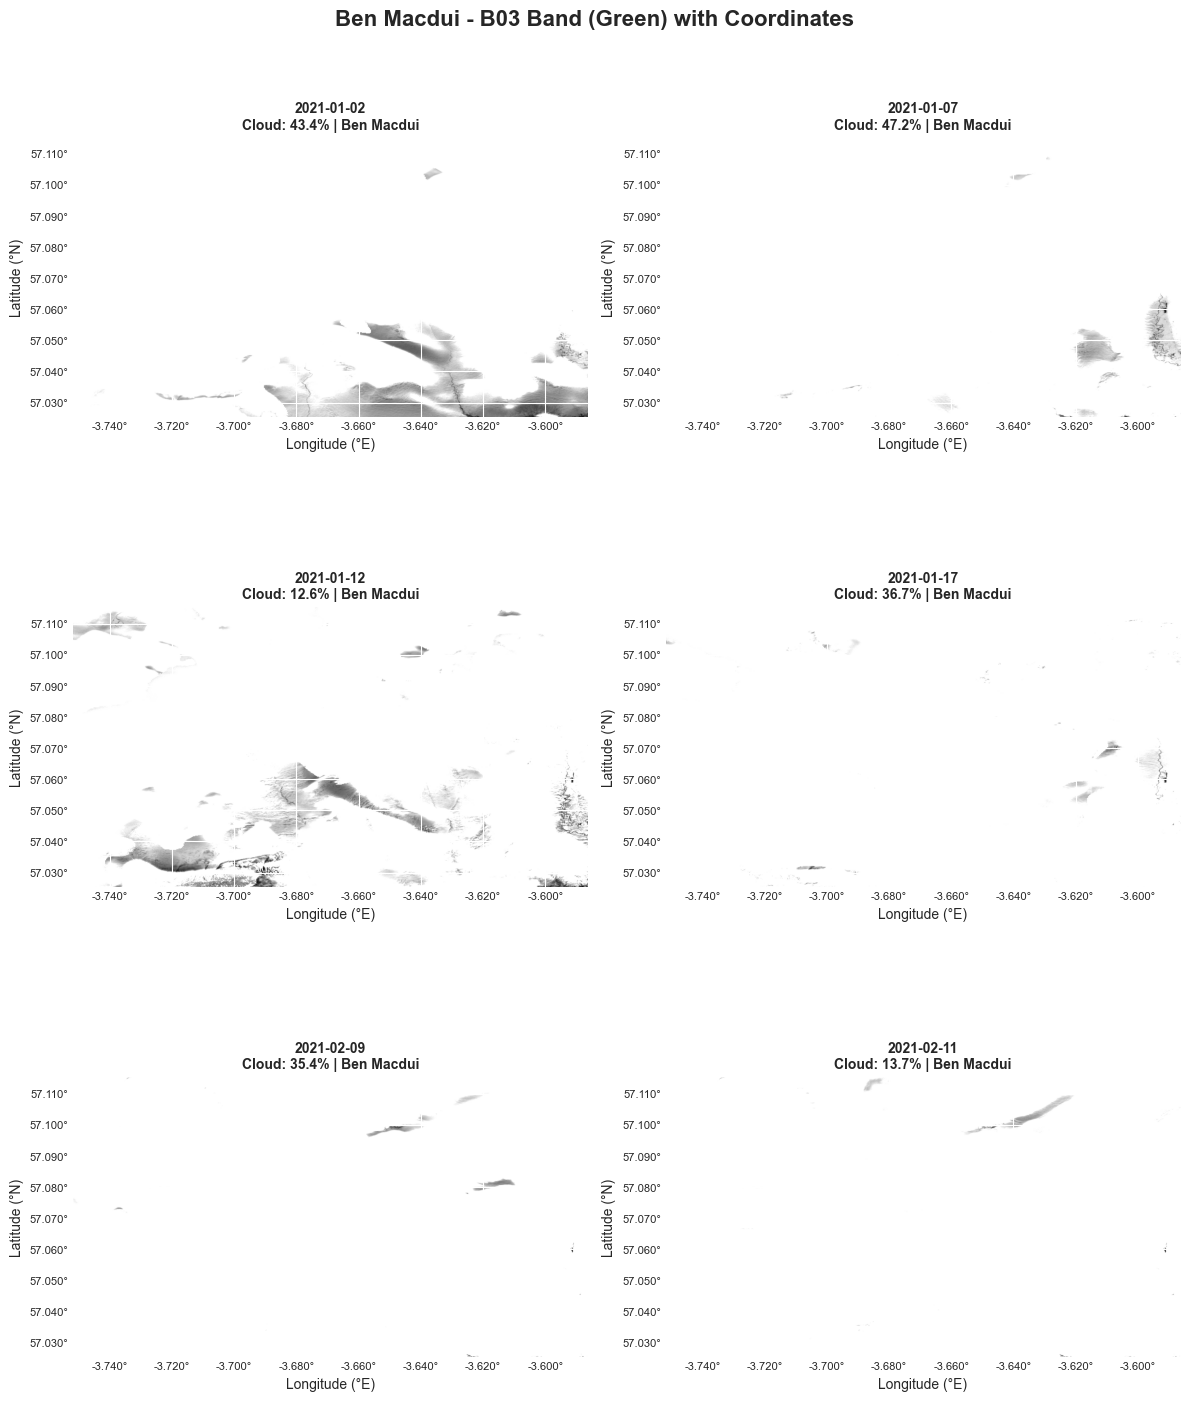

In [8]:
# Load B03 images for Ben Macdui
ben_macdui_images = load_b03_images_from_db(session, aoi_name='Ben Macdui', limit=6)
print(f"Loaded {len(ben_macdui_images)} B03 images for Ben Macdui")

if len(ben_macdui_images) > 0:
    fig = plot_b03_with_coordinates(
        ben_macdui_images,
        title="Ben Macdui - B03 Band (Green) with Coordinates",
        ncols=2,
        brightness_factor=3.0
    )
    plt.show()
else:
    print("No images available for Ben Macdui")

## 5. Process Snow Masks

Generate binary snow masks using NDSI (Normalized Difference Snow Index):

$$NDSI = \frac{B03 - B11}{B03 + B11}$$

Where:
- B03 = Green band (560 nm)
- B11 = SWIR-1 band (1610 nm)

Pixels with NDSI > 0.4 are classified as snow.

In [9]:
# Process snow masks for Ben Nevis
ben_nevis_stats = compute_snow_masks_for_aoi(
    session=session,
    aoi_name='Ben Nevis',
    ndsi_threshold=0.4,
    save_masks=True
)

print(f"\nBen Nevis Summary:")
print(f"  Processed: {ben_nevis_stats['products_processed']} products")
print(f"  Failed: {ben_nevis_stats['products_failed']} products")
print(f"  Average snow coverage: {ben_nevis_stats['avg_snow_pct']:.1f}%")


Computing snow masks for: Ben Nevis
  NDSI threshold: 0.4
  Save masks: True
  Found 313 downloaded products
  [1/313] 2020-12-06... ✓ Snow: 74.5%
  [2/313] 2020-12-06... ✓ Snow: 74.5%
  [3/313] 2020-12-23... ✓ Snow: 59.6%
  [4/313] 2021-01-02... ✓ Snow: 63.9%
  [5/313] 2021-01-02... ✓ Snow: 63.9%
  [6/313] 2021-01-05... ✓ Snow: 86.8%
  [7/313] 2021-01-05... ✓ Snow: 86.8%
  [8/313] 2021-01-07... ✓ Snow: 75.8%
  [9/313] 2021-01-12... ✓ Snow: 59.3%
  [10/313] 2021-01-12... ✓ Snow: 59.3%
  [11/313] 2021-01-20... ✓ Snow: 45.1%
  [12/313] 2021-01-20... ✓ Snow: 45.1%
  [13/313] 2021-01-22... ✓ Snow: 62.9%
  [14/313] 2021-01-25... ✓ Snow: 80.0%
  [15/313] 2021-01-25... ✓ Snow: 80.0%
  [16/313] 2021-02-09... ✓ Snow: 76.5%
  [17/313] 2021-02-09... ✓ Snow: 76.5%
  [18/313] 2021-02-11... ✓ Snow: 75.7%
  [19/313] 2021-02-11... ✓ Snow: 75.7%
  [20/313] 2021-03-01... ✓ Snow: 17.3%
  [21/313] 2021-03-01... ✓ Snow: 17.3%
  [22/313] 2021-03-16... ✓ Snow: 28.0%
  [23/313] 2021-03-16... ✓ Snow: 28.0%
  

In [10]:
# Process snow masks for Ben Macdui
ben_macdui_stats = compute_snow_masks_for_aoi(
    session=session,
    aoi_name='Ben Macdui',
    ndsi_threshold=0.4,
    save_masks=True
)

print(f"\nBen Macdui Summary:")
print(f"  Processed: {ben_macdui_stats['products_processed']} products")
print(f"  Failed: {ben_macdui_stats['products_failed']} products")
print(f"  Average snow coverage: {ben_macdui_stats['avg_snow_pct']:.1f}%")


Computing snow masks for: Ben Macdui
  NDSI threshold: 0.4
  Save masks: True
  Found 164 downloaded products
  [1/164] 2021-01-02... ✓ Snow: 84.1%
  [2/164] 2021-01-07... ✓ Snow: 73.3%
  [3/164] 2021-01-12... ✓ Snow: 92.2%
  [4/164] 2021-01-17... ✓ Snow: 88.0%
  [5/164] 2021-02-09... ✓ Snow: 98.3%
  [6/164] 2021-02-11... ✓ Snow: 100.0%
  [7/164] 2021-02-26... ✓ Snow: 72.2%
  [8/164] 2021-03-01... ✓ Snow: 68.3%
  [9/164] 2021-03-16... ✓ Snow: 52.0%
  [10/164] 2021-03-18... ✓ Snow: 42.8%
  [11/164] 2021-04-12... ✓ Snow: 63.8%
  [12/164] 2021-04-15... ✓ Snow: 36.9%
  [13/164] 2021-04-17... ✓ Snow: 29.9%
  [14/164] 2021-04-22... ✓ Snow: 24.0%
  [15/164] 2021-04-25... ✓ Snow: 19.8%
  [16/164] 2021-06-29... ✓ Snow: 0.3%
  [17/164] 2021-07-01... ✓ Snow: 0.3%
  [18/164] 2021-07-16... ✓ Snow: 0.0%
  [19/164] 2021-07-19... ✓ Snow: 0.5%
  [20/164] 2021-07-21... ✓ Snow: 0.1%
  [21/164] 2021-08-18... ✓ Snow: 0.0%
  [22/164] 2021-08-25... ✓ Snow: 0.4%
  [23/164] 2021-09-02... ✓ Snow: 0.2%
  [24/16

## 6. Analyze Year-Round Snow Coverage Trends

Extract time series data and visualize continuous snow coverage trends throughout all seasons.

In [11]:
# Get trend data for all AOIs
trends_df = analyze_snow_trends(session)

print(f"Loaded {len(trends_df)} data points")
if len(trends_df) > 0:
    print(f"Date range: {trends_df['date'].min()} to {trends_df['date'].max()}")
    print(f"AOIs: {trends_df['aoi_name'].unique().tolist()}")
    print(f"\nFirst few records:")
    print(trends_df.head())
    
    # Add temporal columns for analysis
    trends_df['year'] = pd.to_datetime(trends_df['date']).dt.year
    trends_df['month'] = pd.to_datetime(trends_df['date']).dt.month
    trends_df['day_of_year'] = pd.to_datetime(trends_df['date']).dt.dayofyear

Loaded 477 data points
Date range: 2020-12-06 11:45:25.742000 to 2025-12-30 11:45:40.666000
AOIs: ['Ben Nevis', 'Ben Macdui']

First few records:
                     date    aoi_name   snow_pct  snow_pixels  total_pixels  \
0 2020-12-06 11:45:25.742   Ben Nevis  74.545555       757356       1015964   
1 2020-12-06 11:45:39.719   Ben Nevis  74.545555       757356       1015964   
2 2020-12-23 11:35:26.036   Ben Nevis  59.624652       605765       1015964   
3 2021-01-02 11:35:23.661  Ben Macdui  84.058165       859873       1022950   
4 2021-01-02 11:35:27.790   Ben Nevis  63.895768       649158       1015964   

   cloud_cover  
0        34.63  
1         2.26  
2        43.27  
3        43.42  
4        33.68  


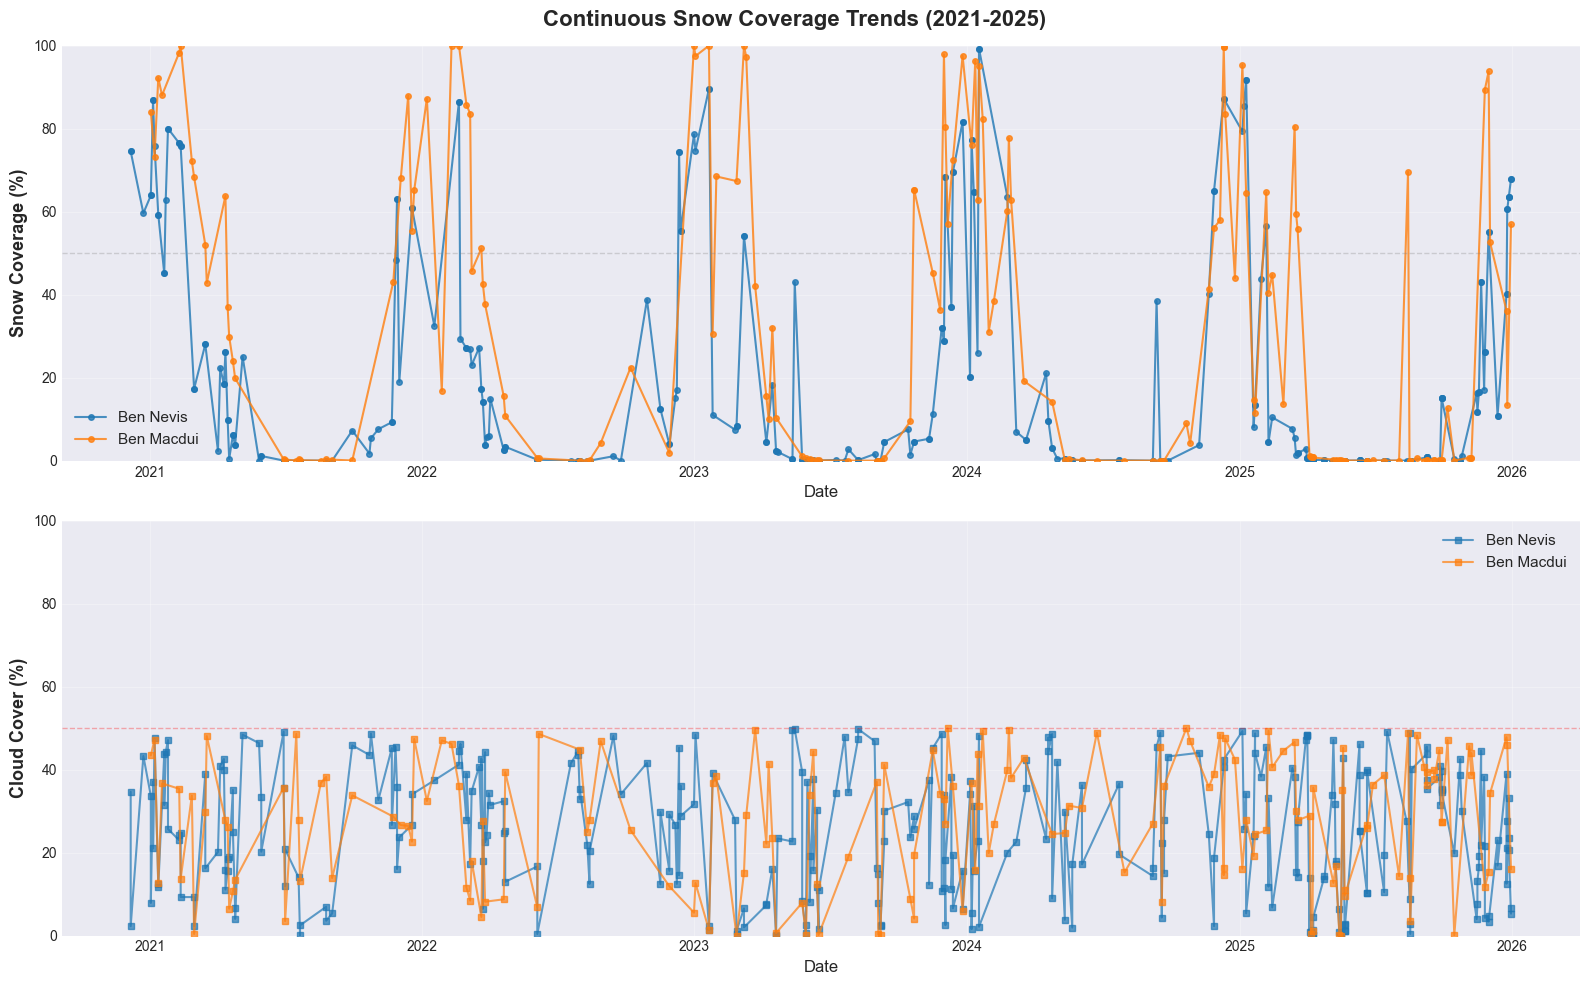

In [12]:
# Plot continuous time series for entire period
if len(trends_df) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('Continuous Snow Coverage Trends (2021-2025)', fontsize=16, fontweight='bold')
    
    # Plot 1: Snow coverage percentage over time
    for aoi_name in trends_df['aoi_name'].unique():
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name].sort_values('date')
        ax1.plot(aoi_data['date'], aoi_data['snow_pct'],
                marker='o', label=aoi_name, linewidth=1.5, markersize=4, alpha=0.8)
    
    ax1.set_ylabel('Snow Coverage (%)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_ylim(0, 100)
    ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Plot 2: Cloud cover over time
    for aoi_name in trends_df['aoi_name'].unique():
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name].sort_values('date')
        ax2.plot(aoi_data['date'], aoi_data['cloud_cover'],
                marker='s', label=aoi_name, linewidth=1.5, markersize=4, alpha=0.7)
    
    ax2.set_ylabel('Cloud Cover (%)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    ax2.set_ylim(0, 100)
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Threshold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trend data available")

## 7. Monthly Patterns Across All Years

Analyze average snow coverage by month to identify seasonal patterns.


Average Snow Coverage by Month (All Years):
                 snow_pct             
                     mean    std count
aoi_name   month                      
Ben Macdui 1        68.40  30.40    20
           2        67.18  26.78    14
           3        60.25  23.30    16
           4        17.92  16.74    16
           5         0.23   0.31    12
           6         0.19   0.21    12
           7         0.11   0.18     8
           8         7.49  21.85    10
           9         0.12   0.16    18
           10       23.52  26.57     8
           11       37.17  34.16    11
           12       69.75  24.56    19
Ben Nevis  1        61.24  28.31    34
           2        44.70  34.44    15
           3        16.08  14.35    28
           4         6.30   7.77    42
           5         2.46   8.91    30
           6         0.06   0.07    23
           7         0.18   0.64    18
           8         0.13   0.42    14
           9         3.85   8.22    31
           10      

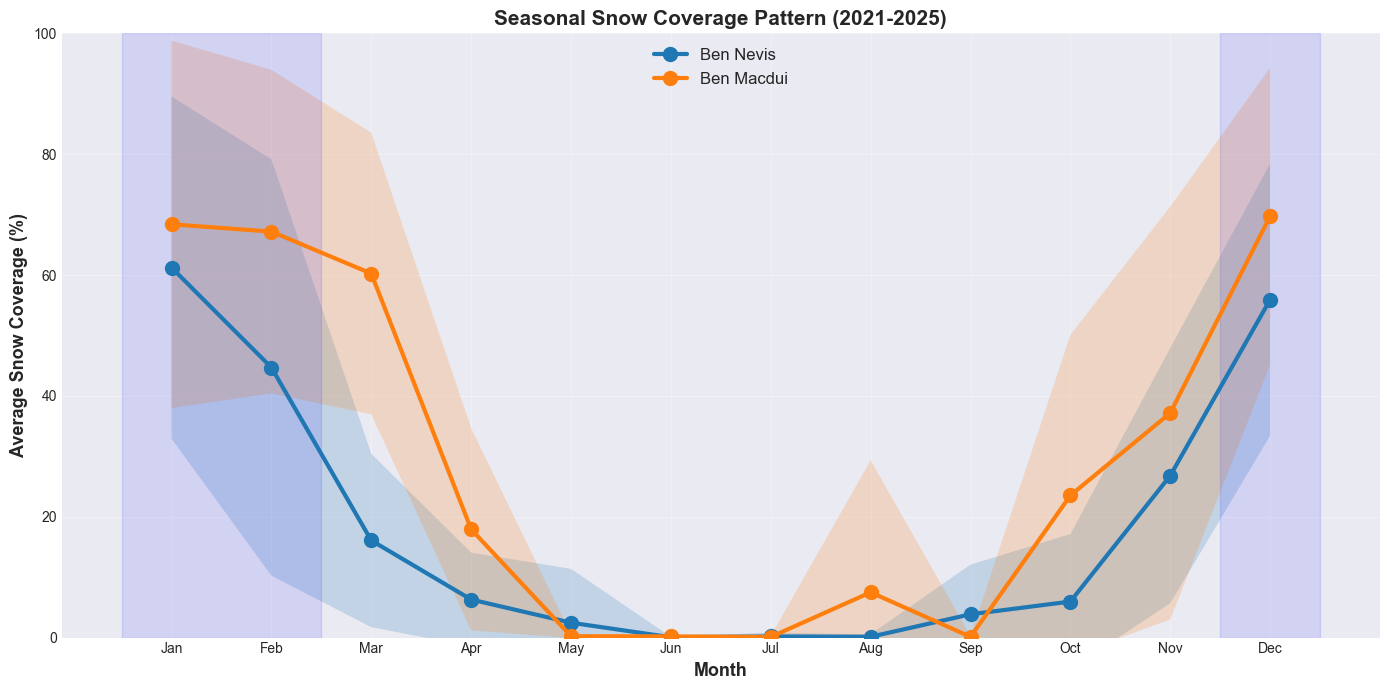

In [13]:
if len(trends_df) > 0:
    # Monthly averages
    monthly_avg = trends_df.groupby(['aoi_name', 'month']).agg({
        'snow_pct': ['mean', 'std', 'count']
    }).round(2)
    
    print("\nAverage Snow Coverage by Month (All Years):")
    print(monthly_avg)
    
    # Plot monthly averages
    fig, ax = plt.subplots(figsize=(14, 7))
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for aoi_name in trends_df['aoi_name'].unique():
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name]
        monthly_means = aoi_data.groupby('month')['snow_pct'].mean()
        monthly_std = aoi_data.groupby('month')['snow_pct'].std()
        
        ax.plot(monthly_means.index, monthly_means.values, marker='o', 
                linewidth=3, markersize=10, label=aoi_name)
        ax.fill_between(monthly_means.index, 
                        monthly_means.values - monthly_std.values,
                        monthly_means.values + monthly_std.values,
                        alpha=0.2)
    
    ax.set_xlabel('Month', fontsize=13, fontweight='bold')
    ax.set_ylabel('Average Snow Coverage (%)', fontsize=13, fontweight='bold')
    ax.set_title('Seasonal Snow Coverage Pattern (2021-2025)', fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_ylim(0, 100)
    
    # Add shaded region for winter months
    ax.axvspan(11.5, 12.5, alpha=0.1, color='blue', label='Winter')
    ax.axvspan(0.5, 2.5, alpha=0.1, color='blue')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for monthly analysis")

## 8. Year-by-Year Comparison

Compare snow coverage across different years to identify trends.


Summary Statistics by AOI and Year:
                snow_pct                             cloud_cover
                    mean    std    min     max count        mean
aoi_name   year                                                 
Ben Macdui 2021    43.70  35.97   0.00   99.99    29       27.20
           2022    38.40  38.76   0.00  100.00    21       25.28
           2023    39.43  38.38   0.00   99.99    33       22.14
           2024    40.41  36.92   0.00   99.55    30       34.21
           2025    19.17  30.09   0.00   95.38    51       28.32
Ben Nevis  2020    69.57   8.61  59.62   74.55     3       26.72
           2021    29.50  30.14   0.00   86.80    59       25.90
           2022    19.95  25.42   0.00   86.49    46       29.34
           2023    18.49  27.72   0.00   89.55    63       20.88
           2024    25.35  33.55   0.00   99.26    42       26.34
           2025    14.80  24.57   0.00   91.68   100       23.68


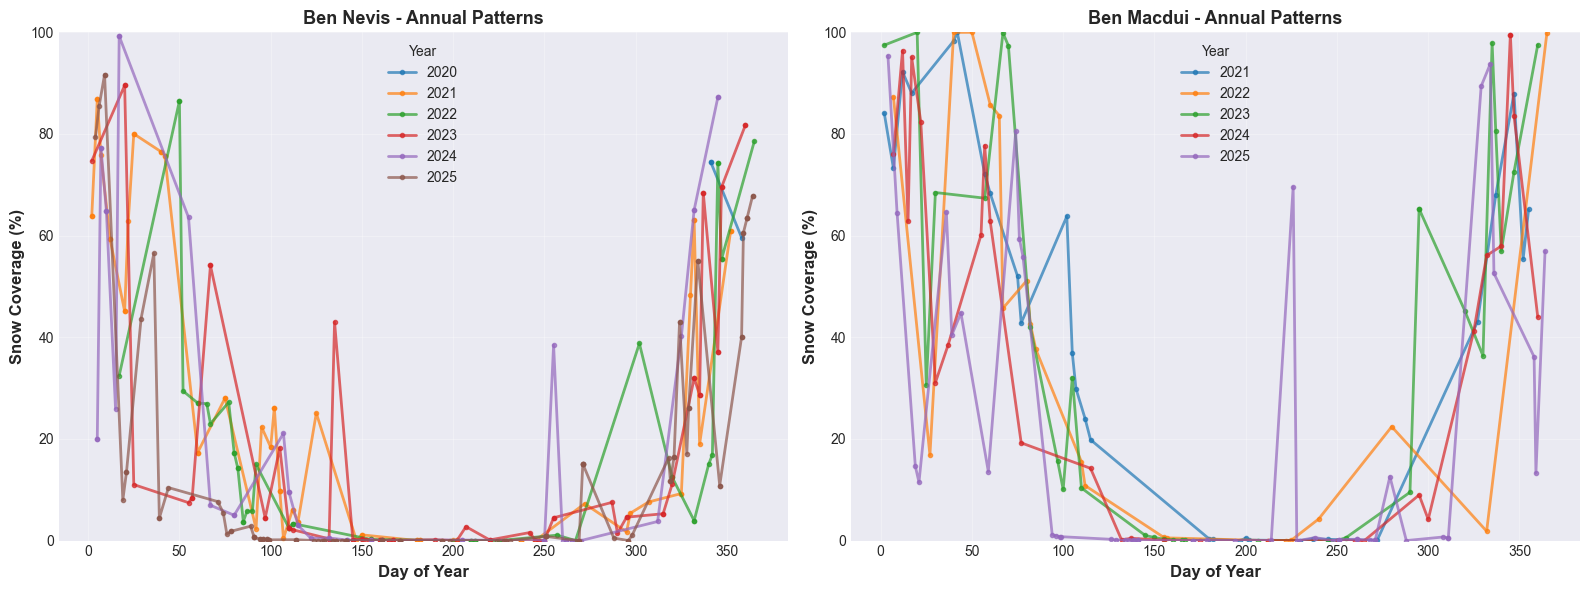

In [14]:
if len(trends_df) > 0:
    # Summary by AOI and year
    summary = trends_df.groupby(['aoi_name', 'year']).agg({
        'snow_pct': ['mean', 'std', 'min', 'max', 'count'],
        'cloud_cover': 'mean'
    }).round(2)
    
    print("\nSummary Statistics by AOI and Year:")
    print(summary)
    
    # Plot year-by-year comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for idx, aoi_name in enumerate(trends_df['aoi_name'].unique()):
        ax = axes[idx]
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name]
        
        for year in sorted(aoi_data['year'].unique()):
            year_data = aoi_data[aoi_data['year'] == year].sort_values('day_of_year')
            ax.plot(year_data['day_of_year'], year_data['snow_pct'],
                   label=f'{year}', linewidth=2, marker='o', markersize=3, alpha=0.7)
        
        ax.set_xlabel('Day of Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('Snow Coverage (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{aoi_name} - Annual Patterns', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(title='Year', fontsize=10)
        ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for year comparison")

## 9. Overall Summary Statistics

Calculate comprehensive statistics across all years and locations.

In [15]:
if len(trends_df) > 0:
    # Overall summary by AOI
    overall_summary = trends_df.groupby('aoi_name').agg({
        'snow_pct': ['mean', 'std', 'min', 'max'],
        'cloud_cover': 'mean',
        'date': 'count'
    }).round(2)
    
    print("\nOverall Summary by AOI (All Years):")
    print(overall_summary)
    print()
    
    # Seasonal statistics (define seasons)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    
    trends_df['season'] = trends_df['month'].apply(get_season)
    
    seasonal_summary = trends_df.groupby(['aoi_name', 'season']).agg({
        'snow_pct': ['mean', 'std', 'count']
    }).round(2)
    
    print("\nSeasonal Summary:")
    print(seasonal_summary)
else:
    print("No data available for summary statistics")


Overall Summary by AOI (All Years):
           snow_pct                     cloud_cover  date
               mean    std  min     max        mean count
aoi_name                                                 
Ben Macdui    33.93  36.30  0.0  100.00       27.57   164
Ben Nevis     21.01  28.41  0.0   99.26       24.75   313


Seasonal Summary:
                  snow_pct             
                      mean    std count
aoi_name   season                      
Ben Macdui Autumn    16.20  27.15    37
           Spring    28.49  30.44    44
           Summer     2.60  12.67    30
           Winter    68.56  26.96    53
Ben Nevis  Autumn    13.92  18.87    73
           Spring     7.88  11.55   100
           Summer     0.12   0.42    55
           Winter    56.07  27.52    85


## Conclusion

This notebook demonstrates:
1. ✓ AOI definition with geographic coordinates
2. ✓ Year-round data acquisition from Copernicus Data Space (2021-2025)
3. ✓ Snow mask generation using NDSI threshold (>0.4)
4. ✓ B03 band visualization with lat/lon axes
5. ✓ Continuous time series analysis across all seasons
6. ✓ Monthly and seasonal pattern identification
7. ✓ Year-by-year comparison and trend analysis

The complete pipeline now provides comprehensive year-round snow monitoring capabilities.

In [16]:
# Close database session
session.close()
print("✓ Database session closed")

✓ Database session closed
